In [18]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt 
import more_itertools
import random
from torchmetrics import Accuracy

# Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

# Setup random seed
RANDOM_SEED = 42

In [2]:
df = pd.read_csv('../HN Score, Title 10k.csv')
df.title = df.title.str.lower()
df.dropna(inplace= True)
df.head()

,score,title
0,8.0,nasa's 3d-printed rotating detonation rocket e...
1,62.0,heat pumps of the 1800s are becoming the techn...
2,1.0,why you should develop local-first web apps
3,1.0,tool to make twitter archive publishable
4,2.0,fedora packages versus upstream flatpaks


In [3]:
words = []
num_lines = 10000
lines = df.title.tolist()[:num_lines]

for i in df.title[:num_lines]:
    for j in str(i).split():
        if j not in words and j != "nan":
            words.append(j)

vocab_size = len(words)

vocab_size, len(lines)

(17110, 7872)

In [4]:
itos = {num:word for num, word in zip(range(len(words)),words)}
stoi = {word:num for num,word in itos.items()}

In [5]:
def create_skipgram_pairs(input_lines, word_to_ix, context_len=3):
    """
    Create skipgram pairs from lines of text.
    Returns: tuple of (input_indices, context_indices)
    """
    context_words = []
    input_words = []
    middle_index = context_len // 2

    for line in input_lines:
        words = line.strip().split()
        
        if len(words) >= context_len:
            windows = list(more_itertools.windowed(words, context_len))
            
            for window in windows:
                center = window[middle_index]
                context = [window[0], window[2]]
                
                input_words.append(center)
                context_words.append(context)

    # Convert to indices
    input_indices = [word_to_ix[word] for word in input_words]
    context_indices = [[word_to_ix[w] for w in context] for context in context_words]
    
    return input_indices, context_indices



In [10]:
# Usage:
context_len = 3
input_indices, context_indices = create_skipgram_pairs(lines, stoi, context_len)
X = torch.tensor(input_indices, dtype=torch.long)
Y = torch.tensor(context_indices, dtype=torch.long)

In [11]:
X.shape, Y.shape
X[:10], Y[:10]

(tensor([ 1,  2,  3,  4,  5,  6,  7, 10, 11, 12]),
 tensor([[ 0,  2],
         [ 1,  3],
         [ 2,  4],
         [ 3,  5],
         [ 4,  6],
         [ 5,  7],
         [ 6,  8],
         [ 9, 11],
         [10, 12],
         [11, 13]]))

In [12]:
inputs_len = len(X)
print("Dataset size:", inputs_len, "; context length:", context_len, "; vocab size:", vocab_size)

Dataset size: 48259 ; context length: 3 ; vocab size: 17110


In [13]:
# # Convert targets to indices
# input_indices = [stoi[input] for input in inputs if input in stoi]

# # Convert context words to indices
# context_indices = [[stoi[context] for context in contexts if context in stoi] for contexts in context_words]

# print(input_indices[:10])
# print(context_indices[:10])


In [14]:
# # Convert target indices to PyTorch tensor
# X = torch.tensor(input_indices, dtype=torch.long)

# Y = torch.tensor(context_indices, dtype=torch.long)

# # Create one-hot encoded targets (X)
# # X = torch.zeros((targets_len, vocab_size))
# # X.scatter_(1, target_indices.unsqueeze(1), 1)  # Scatter 1s into the appropriate indices
# # X = X.long()

# # Convert context indices to PyTorch tensor and one-hot encode (Y)
# # Y = torch.zeros((inputs_len, vocab_size))
# # for i, context in enumerate(context_indices):
# #     Y[i, context] = 1  # Set 1s for all indices in the context for each target

# X.shape, Y.shape

In [15]:
emb_dims = 20

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, emb_dims):
        super().__init__()
        self.embeddings = nn.Embedding(num_embeddings= vocab_size, embedding_dim= emb_dims)
        self.output_weights = nn.Linear(in_features = emb_dims, out_features = vocab_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, positive_samples, negative_samples):
        emb = self.embeddings(x)
        context_weights = self.output_weights.weight[positive_samples]
        negative_sample_weights = self.output_weights.weight[negative_samples]
        positive_out = torch.bmm(context_weights, emb.unsqueeze(-1)).squeeze(-1)
        negative_out = torch.bmm(negative_sample_weights, emb.unsqueeze(-1)).squeeze(-1)
        positive_out = self.sigmoid(positive_out)
        negative_out = self.sigmoid(negative_out)
        positive_loss = -positive_out.log().mean()
        negative_loss = -(1 - negative_out + 10**(-3)).log().mean()
        return positive_loss + negative_loss

word2vec = Word2Vec(vocab_size = vocab_size, emb_dims= emb_dims)


In [16]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimiser = torch.optim.SGD(params= word2vec.parameters(), lr = 0.1)

In [17]:
## TODO: Uncomment this code to use the Accuracy function
# acc_fn = Accuracy(task="multiclass", num_classes=vocab_size) # send accuracy function to device

In [19]:
def evaluate_accuracy(model, X, Y, vocab_size):
    """
    Calculate accuracy by comparing positive sample scores with negative sample scores.
    We want positive context words to have higher scores than random negative words.
    """
    model.eval()
    
    with torch.no_grad():
        # Get embeddings for all input words
        emb = model.embeddings(X)  # [num_samples, embedding_dim]
        
        # Get positive context embeddings
        pos_ctx = model.output_weights.weight[Y]  # [num_samples, 2, embedding_dim]
        
        # Generate negative samples
        neg_samples = torch.randint(0, vocab_size, Y.shape)
        neg_ctx = model.output_weights.weight[neg_samples]
        
        # Calculate similarity scores
        emb_reshaped = emb.unsqueeze(-1)  # [num_samples, embedding_dim, 1]
        pos_scores = torch.bmm(pos_ctx, emb_reshaped).squeeze(-1)  # [num_samples, 2]
        neg_scores = torch.bmm(neg_ctx, emb_reshaped).squeeze(-1)  # [num_samples, 2]
        
        # Accuracy: how often positive scores > negative scores
        accuracy = (pos_scores > neg_scores).float().mean().item()
        
    return accuracy

In [20]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 100
batch_size = 32
# Track loss
lossi = []

# Send data to the device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=32, 
                                         shuffle=True, 
                                         drop_last=True)

# Loop through the data
for epoch in range(epochs):
    ### Training
    total_loss = 0  # Track loss across batches
    
    for batch_idx, batch in enumerate(dataloader):
        # Unpack batch
        X_batch, positive_samples = batch
        # Generate negative samples
        negative_samples = torch.randint(0, vocab_size, (X_batch.size(0), context_len -1))

        # 1. Forward pass (now returns loss directly)
        loss = word2vec(X_batch, negative_samples, positive_samples)  # Model computes loss internally
        
        # 2. Zero the gradients
        optimiser.zero_grad()
        
        # 3. Loss backwards
        loss.backward()
        
        # 4. Step the optimiser
        optimiser.step()
        
        total_loss += loss.item()

        # Track loss
        lossi.append(loss.item())
        
        # if batch_idx % 100 == 0:
    accuracy = evaluate_accuracy(word2vec, X, Y, vocab_size)
    print(f"Epoch {epoch + 1} | Loss: {loss.item():.5f} | Accuracy: {accuracy:.4f}")

    # print(f"Epoch {epoch + 1} | Batch {batch_idx + 1} | Loss: {loss.item():.5f}")
    # Print out what's happening every 100 epochs
    # if epoch % 100 == 0:
    #     avg_loss = total_loss / len(dataloader)
    #     print(f"Epoch: {epoch} | Average Loss: {avg_loss:.5f}")



Epoch 1 | Loss: 1.49084 | Accuracy: 0.4695
Epoch 2 | Loss: 1.44492 | Accuracy: 0.4594
Epoch 3 | Loss: 1.38255 | Accuracy: 0.4451
Epoch 4 | Loss: 1.43047 | Accuracy: 0.4375
Epoch 5 | Loss: 1.36800 | Accuracy: 0.4308
Epoch 6 | Loss: 1.42882 | Accuracy: 0.4235
Epoch 7 | Loss: 1.31650 | Accuracy: 0.4141
Epoch 8 | Loss: 1.31890 | Accuracy: 0.4087
Epoch 9 | Loss: 1.32125 | Accuracy: 0.3985
Epoch 10 | Loss: 1.38332 | Accuracy: 0.3928
Epoch 11 | Loss: 1.40632 | Accuracy: 0.3867
Epoch 12 | Loss: 1.31403 | Accuracy: 0.3780
Epoch 13 | Loss: 1.39135 | Accuracy: 0.3725
Epoch 14 | Loss: 1.36997 | Accuracy: 0.3627
Epoch 15 | Loss: 1.36401 | Accuracy: 0.3633
Epoch 16 | Loss: 1.39583 | Accuracy: 0.3559
Epoch 17 | Loss: 1.28562 | Accuracy: 0.3500
Epoch 18 | Loss: 1.40235 | Accuracy: 0.3436
Epoch 19 | Loss: 1.20028 | Accuracy: 0.3361
Epoch 20 | Loss: 1.23924 | Accuracy: 0.3328
Epoch 21 | Loss: 1.24311 | Accuracy: 0.3250
Epoch 22 | Loss: 1.27683 | Accuracy: 0.3239
Epoch 23 | Loss: 1.24439 | Accuracy: 0.31

In [381]:
def evaluate_accuracy(model, X, Y, vocab_size):
    """
    Calculate accuracy over the entire dataset at once.
    
    Args:
        model: The Word2Vec model
        X: Tensor of input words [num_samples]
        Y: Tensor of context words [num_samples, 2]
    """
    model.eval()
    
    with torch.no_grad():
        # Get embeddings for all input words
        emb = model.embeddings(X)  # [num_samples, embedding_dim]
        
        # Get context embeddings
        ctx = model.output_weights.weight[Y]  # [num_samples, 2, embedding_dim]
        
        # Calculate similarity scores
        emb_reshaped = emb.unsqueeze(-1)  # [num_samples, embedding_dim, 1]
        scores = torch.bmm(ctx, emb_reshaped).squeeze(-1)  # [num_samples, 2]
        
        # Convert to predictions (0 or 1)
        predictions = (torch.sigmoid(scores) > 0.5).float()
        
        # Calculate accuracy
        accuracy = (predictions == 1).float().mean().item()
        
    return accuracy

# Usage:
accuracy = evaluate_accuracy(word2vec, X, Y, vocab_size)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.0954


In [382]:
def plot_loss(lossi):
    """
    Plot loss values using PyTorch operations.
    """
    losses = torch.tensor(lossi)
    window_size = max(len(losses) // 100, 1)
    
    # Reshape and mean
    remainder = len(losses) % window_size
    if remainder:
        # Pad with the last value to make it evenly divisible
        padding = window_size - remainder
        losses = torch.cat([losses, losses[-1].repeat(padding)])
    
    averaged_losses = losses.view(-1, window_size).mean(1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(averaged_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel(f'Steps (averaged over {window_size} steps)')
    plt.ylabel('Loss')
    plt.show()

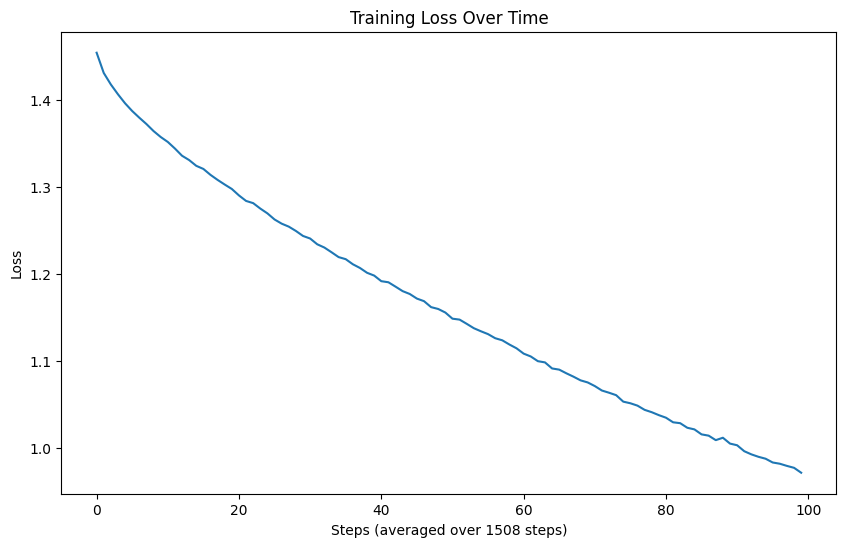

In [383]:
plot_loss(lossi)

In [384]:
# plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [385]:
from sklearn.metrics.pairwise import cosine_similarity

def get_nearest_neighbors(word, stoi, embeddings, n=5):
    """
    Find the top-n nearest neighbors of a word in the embedding space.
    
    Args:
        word (str): The target word.
        stoi (dict): Mapping from words to indices.
        embeddings (torch.Tensor): Learned word embeddings (shape: V x d).
        n (int): Number of nearest neighbors to retrieve.
    
    Returns:
        List of tuples (neighbor_word, similarity_score).
    """
    if word not in stoi:
        return f"'{word}' not in vocabulary."
    
    word_idx = stoi[word]
    word_embedding = embeddings[word_idx].unsqueeze(0)  # Shape: 1 x d
    
    # Compute cosine similarity between the target embedding and all embeddings
    similarities = cosine_similarity(word_embedding.detach().numpy(), embeddings.detach().numpy())
    similarities = similarities[0]  # Flatten
    
    # Get top-n similar words (excluding the word itself)
    nearest_indices = similarities.argsort()[-n-1:][::-1][1:]  # Exclude the word itself
    nearest_words = [(list(stoi.keys())[idx], similarities[idx]) for idx in nearest_indices]
    return nearest_words

# Example usage
word = "2,200"
nearest_neighbors = get_nearest_neighbors(word, stoi, word2vec.embeddings.weight, n=5)
print(f"Nearest neighbors of '{word}':")
print(nearest_neighbors)


Nearest neighbors of '2,200':
[('sector?', 0.7978853), ('favour', 0.7545068), ('cs', 0.73504287), ('twitter?', 0.701852), ('confidentialhistory', 0.68996775)]


In [386]:
# Using random
# Make a copy so you don't shuffle the original list
words_sample = words.copy()
random.shuffle(words_sample)

# Print first 10 shuffled words
print("Random sample of words:")
print(words_sample[:10])

Random sample of words:
['dreams:', 'happend', 'systems’', 'should', 'destructive', 'or,', 'no-code', 'present', 'arxiv', 'ecommerce']
